In [1]:
import os
import time
from tqdm import tqdm

import pandas as pd
import numpy as np
from collections import Counter, defaultdict

from matplotlib import pyplot as plt

import torch
import torchaudio
from datasets import Dataset, DatasetDict, load_dataset, load_metric
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


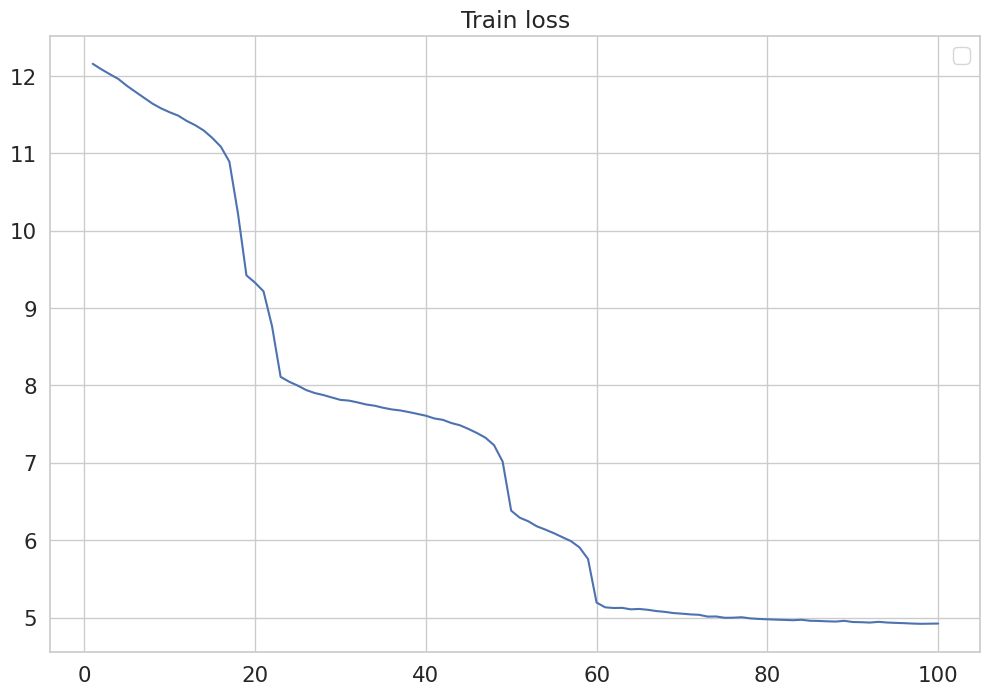

In [27]:
import json
import seaborn as sns

with open('../nn-technologies-lab1/cnn_numpy_implementation/train_errors') as f:
    m = json.load(f)


sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(m['epochs'], m['errors'])
plt.title('Train loss')
plt.legend()
plt.show()

In [2]:
data_path = 'data/'
categories = os.listdir(data_path)
paths_and_cats = defaultdict(list)

for i, category in enumerate(categories):
    
    audio_folder = f'{data_path}{category}/'
    audio_files = os.listdir(audio_folder)

    for audio_file in audio_files:
    
        file_path = f'{data_path}{category}/{audio_file}'
    
        if os.path.getsize(file_path) / (1024 * 1024) < 100:
        
            paths_and_cats['paths'].append(file_path)
            paths_and_cats['labels'].append(i)

print(Counter(paths_and_cats['labels']))
len(paths_and_cats['paths']), len(paths_and_cats['labels'])

Counter({0: 100, 1: 100, 2: 96, 3: 89})


(385, 385)

In [3]:
arraies = []
labels = []
sampling_rates = []
duration = 60

for i in tqdm(range(len(paths_and_cats['labels']))):
    data, sr = torchaudio.load(paths_and_cats['paths'][i], format='mp3')
    data = torchaudio.functional.resample(data, orig_freq=sr, new_freq=16000)[:, :sr * duration]
    if len(data[0]) == 2:
        arraies += [np.array((data[0] + data[1])/2)]
    else:
        arraies += [np.array(data[0])]
    sampling_rates += [sr]
    labels +=  [paths_and_cats['labels'][i]]

100%|██████████| 385/385 [06:45<00:00,  1.05s/it]


In [4]:
df_train_arraies = []
df_valid_arraies = []
df_train_labels = []
df_valid_labels = []
limit = 20
for i in range(len(labels)):
    if df_valid_labels.count(labels[i]) < limit:
        df_valid_labels += [labels[i]]
        df_valid_arraies +=[arraies[i]]
    else:
        df_train_labels += [labels[i]]
        df_train_arraies += [arraies[i]] 

In [5]:
len(df_train_arraies), len(df_valid_arraies), df_train_arraies[0].shape

(305, 80, (2646000,))

In [6]:
tdf = pd.DataFrame({"array": df_train_arraies, "sampling_rate": [0 for i in df_train_arraies ] , "label": df_train_labels })
vdf = pd.DataFrame({"array": df_valid_arraies, "sampling_rate": [0 for i in df_valid_arraies ], "label": df_valid_labels })
tdf = tdf.sample(frac=1).reset_index(drop=True)

tds = Dataset.from_pandas(tdf)
vds = Dataset.from_pandas(vdf)

ds = DatasetDict()
ds["train"] =  tds
ds["validation"] =  vds

In [7]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
feature_extractor

ASTFeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "ASTFeatureExtractor",
  "feature_size": 1,
  "max_length": 1024,
  "mean": -4.2677393,
  "num_mel_bins": 128,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000,
  "std": 4.5689974
}

In [10]:
def preprocess_function(examples):
    audio_arrays = examples["array"]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=int(feature_extractor.sampling_rate * duration), 
        truncation=True,
        padding=True
    )
    return inputs

In [11]:
encoded_dataset = ds.map(preprocess_function, remove_columns=["sampling_rate", "array"], batched=True, batch_size=1)
encoded_dataset

Map:   0%|          | 0/305 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 305
    })
    validation: Dataset({
        features: ['label', 'input_values'],
        num_rows: 80
    })
})

In [ ]:
num_labels = 4
model = AutoModelForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593", num_labels = 4, ignore_mismatched_sizes=True)

In [ ]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593".split("/")[1]
args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_total_limit = 3,
    save_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=2,
    num_train_epochs=30,
    warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

In [ ]:
metric = load_metric("f1", average='macro')

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    print(metric.compute(predictions=predictions, references=eval_pred.label_ids, average='macro'))
    return metric.compute(predictions=predictions, references=eval_pred.label_ids, average='macro')

In [ ]:
trainer = Trainer(model,
                  args,
                  train_dataset=encoded_dataset["train"],
                  eval_dataset=encoded_dataset["validation"],
                  tokenizer=feature_extractor,
                  compute_metrics=compute_metrics)

In [ ]:
trainer.train()